# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [40]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

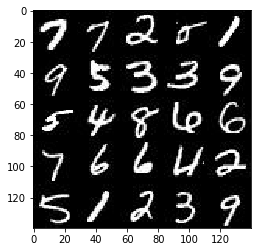

In [41]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

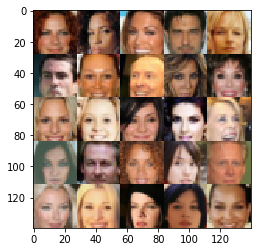

In [42]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [43]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [44]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name="input_real")
    inputs_z = tf.placeholder(tf.float32, [None, z_dim], name="input_z")
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [45]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        conv1 = tf.layers.conv2d(inputs=images, filters=64, kernel_size=5, strides=2, padding='SAME')
        lrelu1 = tf.maximum(alpha * conv1, conv1)
        
        conv2 = tf.layers.conv2d(lrelu1, 128, 5, 2, 'SAME')
        batch_norm2 = tf.layers.batch_normalization(conv2, training=True)
        lrelu2 = tf.maximum(alpha * batch_norm2, batch_norm2)
        
        conv3 = tf.layers.conv2d(lrelu2, 256, 5, 1, 'SAME')
        batch_norm3 = tf.layers.batch_normalization(conv3, training=True)
        lrelu3 = tf.maximum(alpha * batch_norm3, batch_norm3)
        
        conv4 = tf.layers.conv2d(lrelu3, 512, 5, 1, 'SAME')
        batch_norm4 = tf.layers.batch_normalization(conv4, training=True)
        lrelu4 = tf.maximum(alpha * batch_norm4, batch_norm4)
       
        flat = tf.reshape(lrelu4, (-1, 7*7*512))
        
        logits = tf.layers.dense(flat, 1)
        
        out = tf.sigmoid(logits)
        
        return out, logits



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [46]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse=False if is_train==True else True):
        fc1 = tf.layers.dense(z, 7*7*512)
        fc1 = tf.reshape(fc1, (-1, 7, 7, 512))
        fc1 = tf.maximum(alpha*fc1, fc1)
        
        deconv2 = tf.layers.conv2d_transpose(inputs=fc1, filters=256, kernel_size=3, strides=1, padding='SAME')
        batch_norm2 = tf.layers.batch_normalization(deconv2, training=is_train)
        lrelu2 = tf.maximum(alpha * batch_norm2, batch_norm2)
        
        deconv3 = tf.layers.conv2d_transpose(lrelu2, 128, 3, 1, 'SAME')
        batch_norm3 = tf.layers.batch_normalization(deconv3, training=is_train)
        lrelu3 = tf.maximum(alpha * batch_norm3, batch_norm3)
        
        deconv4 = tf.layers.conv2d_transpose(lrelu3, 64, 3, 2, 'SAME')
        batch_norm4 = tf.layers.batch_normalization(deconv4, training=is_train)
        lrelu4 = tf.maximum(alpha * batch_norm4, batch_norm4)
        
        logits = tf.layers.conv2d_transpose(lrelu4, out_channel_dim, 3, 2, 'SAME')
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [47]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_real_model, d_real_logit = discriminator(input_real)
    d_fake_model, d_fake_logit = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_real_logit, 
                                                          labels=tf.ones_like(d_real_logit) * 0.9))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logit, 
                                                          labels=tf.zeros_like(d_real_logit)))
    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logit,
                                                     labels=tf.ones_like(d_fake_logit)))
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [48]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    d_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [49]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [50]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    n_samples, width, height, channels = data_shape
    inputs_real, inputs_z, _ = model_inputs(image_width=width, image_height=height, image_channels=channels,z_dim=z_dim)
    d_loss, g_loss = model_loss(input_real=inputs_real, input_z=inputs_z, out_channel_dim=channels)
    d_train_opt, g_train_opt = model_opt(d_loss=d_loss, g_loss=g_loss, learning_rate=learning_rate, beta1=beta1)

    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_images = batch_images*2
                steps += 1
            
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
            
                _ = sess.run(d_train_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z})
                _ = sess.run(g_train_opt, feed_dict={inputs_z: batch_z})
                
                if steps % 100 == 0:
                    train_loss_d = sess.run(d_loss, {inputs_z: batch_z, inputs_real: batch_images})
                    train_loss_g = g_loss.eval({inputs_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))   
                    
                    _ = show_generator_output(sess, 1, inputs_z, channels, data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.1958... Generator Loss: 3.7575


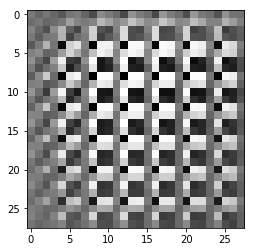

Epoch 1/2... Discriminator Loss: 0.3920... Generator Loss: 8.6606


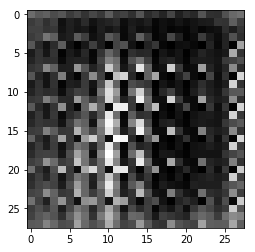

Epoch 1/2... Discriminator Loss: 0.4171... Generator Loss: 5.4005


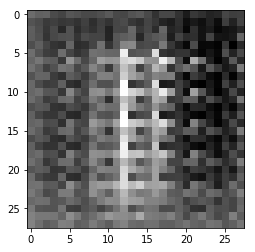

Epoch 1/2... Discriminator Loss: 0.4630... Generator Loss: 3.9949


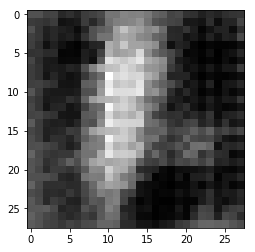

Epoch 1/2... Discriminator Loss: 0.4452... Generator Loss: 5.3676


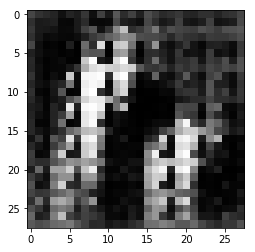

Epoch 1/2... Discriminator Loss: 0.4751... Generator Loss: 7.1085


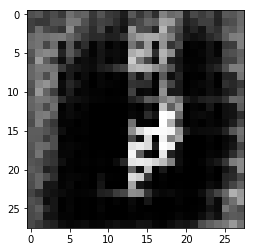

Epoch 1/2... Discriminator Loss: 0.4868... Generator Loss: 7.1522


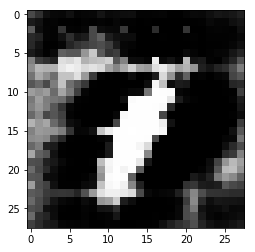

Epoch 1/2... Discriminator Loss: 0.5814... Generator Loss: 6.2625


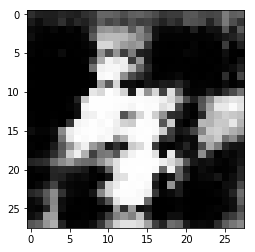

Epoch 1/2... Discriminator Loss: 0.4424... Generator Loss: 3.7413


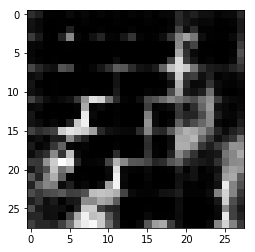

Epoch 1/2... Discriminator Loss: 0.8282... Generator Loss: 3.8041


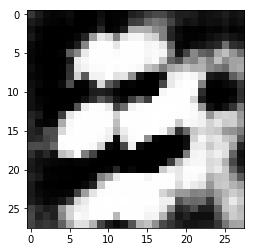

Epoch 1/2... Discriminator Loss: 0.7899... Generator Loss: 7.6145


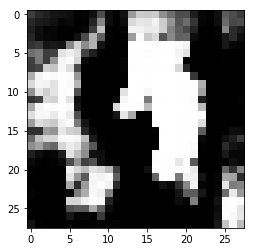

Epoch 1/2... Discriminator Loss: 0.4752... Generator Loss: 4.2877


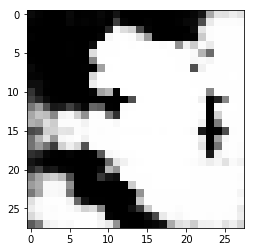

Epoch 1/2... Discriminator Loss: 0.7753... Generator Loss: 2.6150


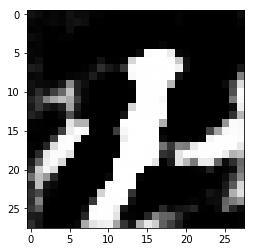

Epoch 1/2... Discriminator Loss: 0.8261... Generator Loss: 1.5779


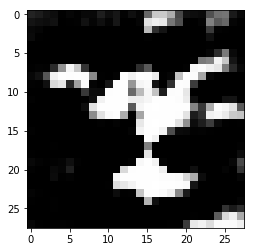

Epoch 1/2... Discriminator Loss: 0.8409... Generator Loss: 1.7771


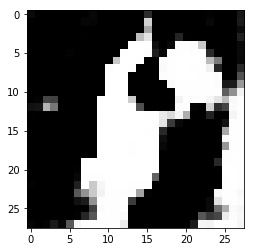

Epoch 1/2... Discriminator Loss: 1.0952... Generator Loss: 1.8298


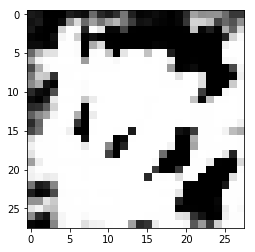

Epoch 1/2... Discriminator Loss: 0.5205... Generator Loss: 3.0461


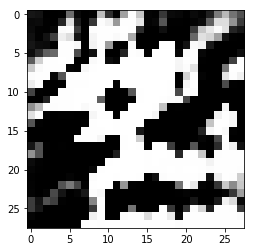

Epoch 1/2... Discriminator Loss: 0.4669... Generator Loss: 6.2154


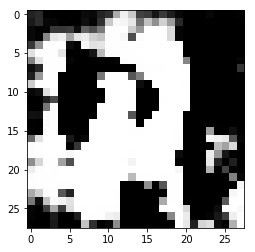

Epoch 1/2... Discriminator Loss: 0.6925... Generator Loss: 2.2909


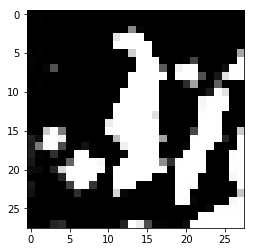

Epoch 1/2... Discriminator Loss: 0.6391... Generator Loss: 2.5100


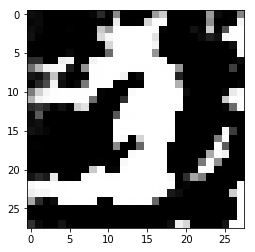

Epoch 1/2... Discriminator Loss: 0.5796... Generator Loss: 5.1113


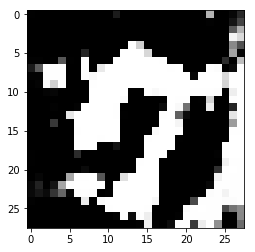

Epoch 1/2... Discriminator Loss: 0.5129... Generator Loss: 3.0975


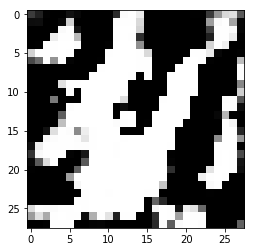

Epoch 1/2... Discriminator Loss: 0.8446... Generator Loss: 1.7041


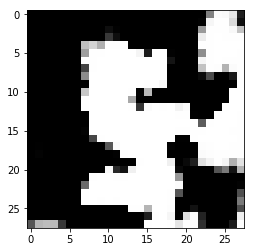

Epoch 1/2... Discriminator Loss: 0.4404... Generator Loss: 4.4418


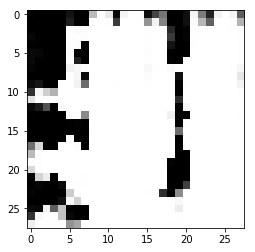

Epoch 1/2... Discriminator Loss: 1.5183... Generator Loss: 0.8330


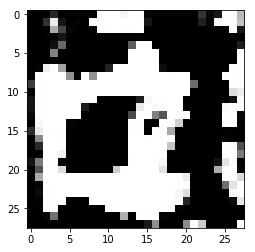

Epoch 1/2... Discriminator Loss: 0.7058... Generator Loss: 6.8451


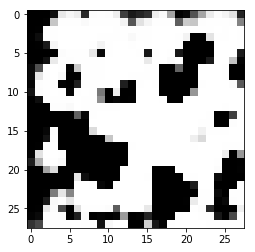

Epoch 1/2... Discriminator Loss: 0.4096... Generator Loss: 6.3440


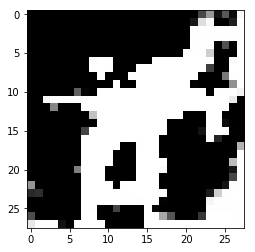

Epoch 1/2... Discriminator Loss: 0.4513... Generator Loss: 5.6299


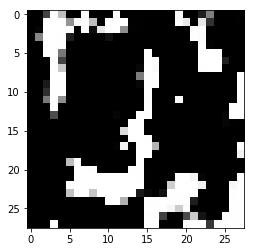

Epoch 1/2... Discriminator Loss: 0.6588... Generator Loss: 1.7274


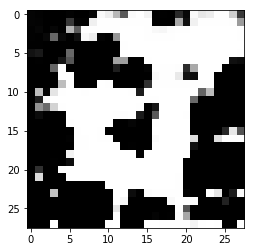

Epoch 1/2... Discriminator Loss: 0.4191... Generator Loss: 3.3318


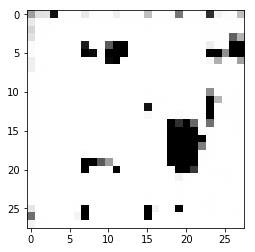

Epoch 1/2... Discriminator Loss: 1.0066... Generator Loss: 6.3329


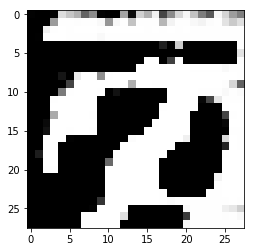

Epoch 1/2... Discriminator Loss: 0.9569... Generator Loss: 2.8753


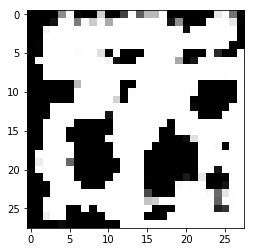

Epoch 1/2... Discriminator Loss: 0.6854... Generator Loss: 2.7974


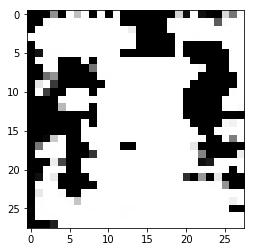

Epoch 1/2... Discriminator Loss: 0.6577... Generator Loss: 1.9725


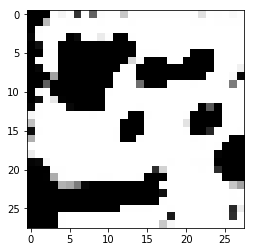

Epoch 1/2... Discriminator Loss: 1.3041... Generator Loss: 0.6928


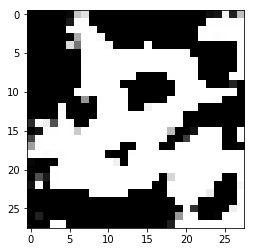

Epoch 1/2... Discriminator Loss: 0.5799... Generator Loss: 2.9043


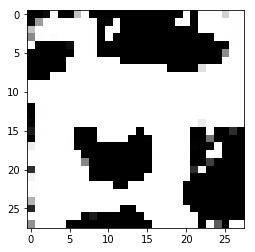

Epoch 1/2... Discriminator Loss: 0.4633... Generator Loss: 4.4900


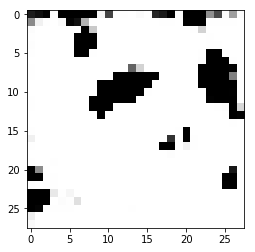

Epoch 1/2... Discriminator Loss: 0.4817... Generator Loss: 2.6636


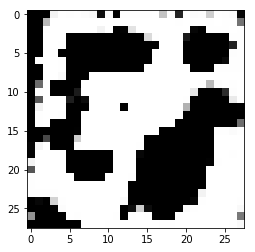

Epoch 1/2... Discriminator Loss: 0.7334... Generator Loss: 1.7397


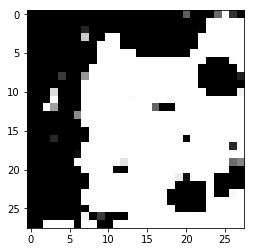

Epoch 1/2... Discriminator Loss: 1.1425... Generator Loss: 0.9837


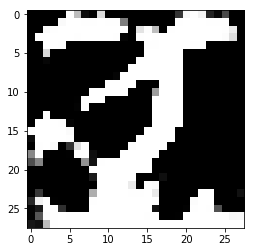

Epoch 1/2... Discriminator Loss: 0.7482... Generator Loss: 2.0675


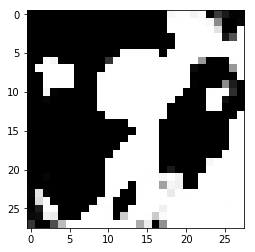

Epoch 1/2... Discriminator Loss: 1.3113... Generator Loss: 2.4066


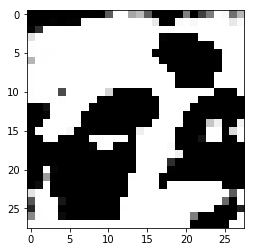

Epoch 1/2... Discriminator Loss: 0.6290... Generator Loss: 4.4496


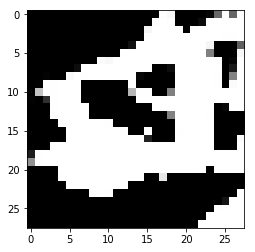

Epoch 1/2... Discriminator Loss: 0.6246... Generator Loss: 2.5735


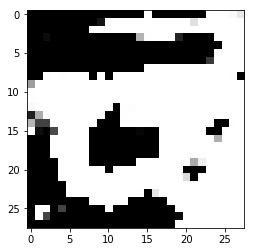

Epoch 1/2... Discriminator Loss: 0.6813... Generator Loss: 2.7819


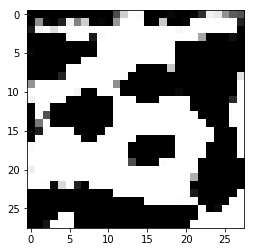

Epoch 1/2... Discriminator Loss: 0.8686... Generator Loss: 1.8659


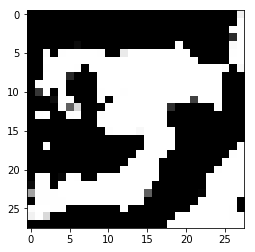

Epoch 1/2... Discriminator Loss: 0.7622... Generator Loss: 1.4707


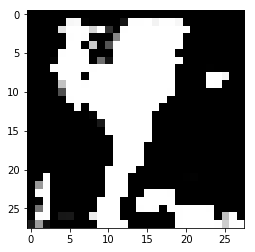

Epoch 1/2... Discriminator Loss: 1.2329... Generator Loss: 3.0631


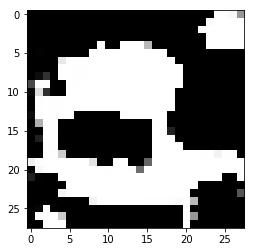

Epoch 1/2... Discriminator Loss: 0.9579... Generator Loss: 2.3252


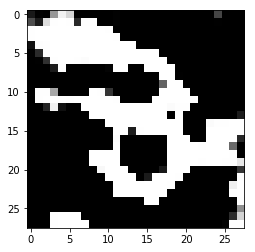

Epoch 1/2... Discriminator Loss: 0.7402... Generator Loss: 3.7815


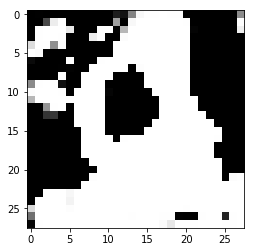

Epoch 1/2... Discriminator Loss: 1.5254... Generator Loss: 0.6101


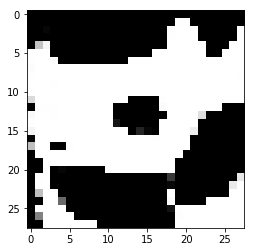

Epoch 1/2... Discriminator Loss: 1.0723... Generator Loss: 2.9473


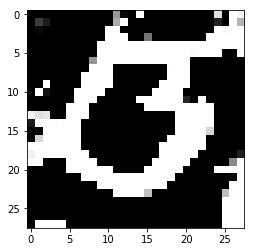

Epoch 1/2... Discriminator Loss: 1.2588... Generator Loss: 0.6426


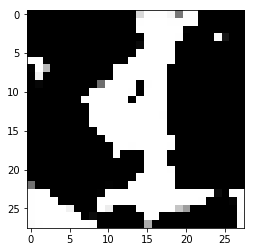

Epoch 1/2... Discriminator Loss: 1.1211... Generator Loss: 1.4103


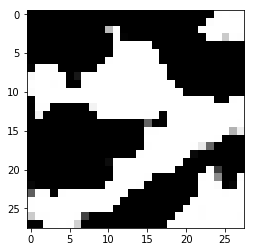

Epoch 1/2... Discriminator Loss: 0.4457... Generator Loss: 3.5882


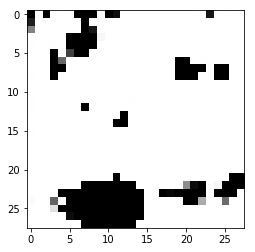

Epoch 1/2... Discriminator Loss: 0.6602... Generator Loss: 1.5370


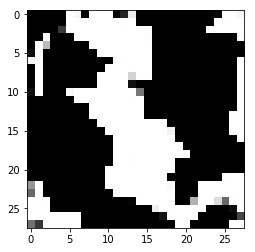

Epoch 1/2... Discriminator Loss: 0.8870... Generator Loss: 1.0699


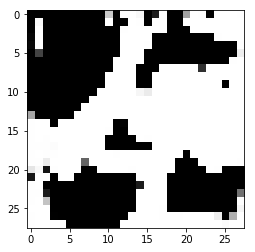

Epoch 1/2... Discriminator Loss: 0.7742... Generator Loss: 2.0304


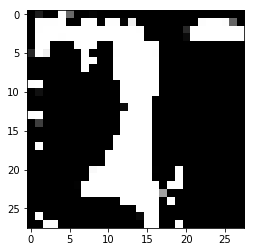

Epoch 1/2... Discriminator Loss: 0.4524... Generator Loss: 3.0836


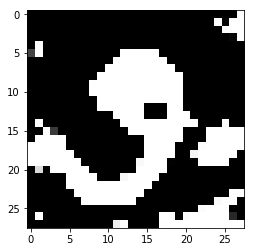

Epoch 1/2... Discriminator Loss: 1.1474... Generator Loss: 0.9312


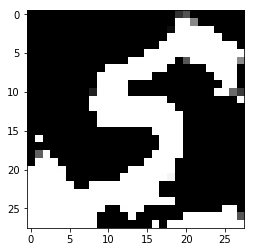

Epoch 2/2... Discriminator Loss: 0.7370... Generator Loss: 3.6311


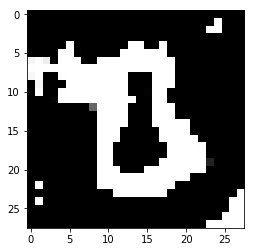

Epoch 2/2... Discriminator Loss: 0.8899... Generator Loss: 1.7264


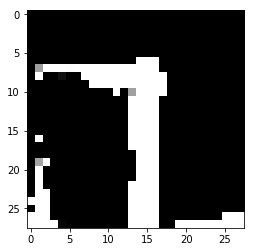

Epoch 2/2... Discriminator Loss: 0.5940... Generator Loss: 3.5893


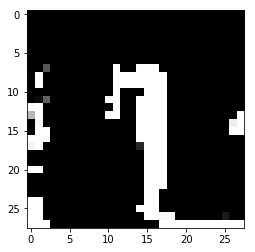

Epoch 2/2... Discriminator Loss: 0.8005... Generator Loss: 4.6645


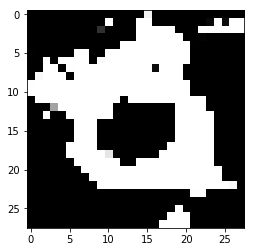

Epoch 2/2... Discriminator Loss: 1.1158... Generator Loss: 0.7351


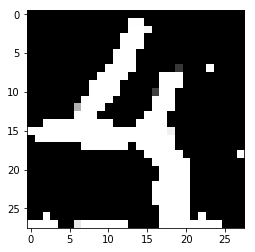

Epoch 2/2... Discriminator Loss: 0.5352... Generator Loss: 2.2262


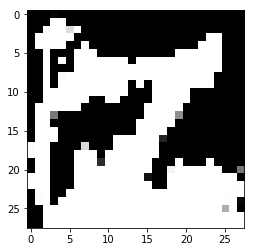

Epoch 2/2... Discriminator Loss: 0.8050... Generator Loss: 4.5240


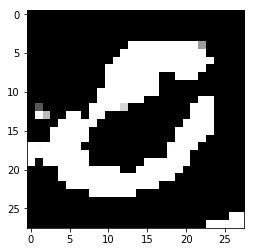

Epoch 2/2... Discriminator Loss: 0.7275... Generator Loss: 1.8833


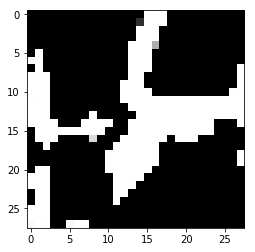

Epoch 2/2... Discriminator Loss: 0.5260... Generator Loss: 2.0612


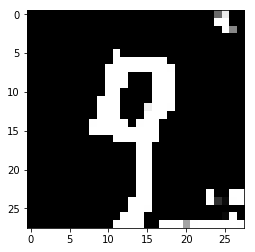

Epoch 2/2... Discriminator Loss: 1.1217... Generator Loss: 1.0191


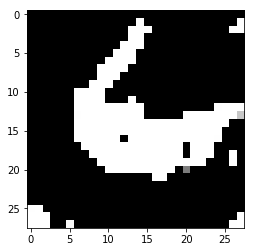

Epoch 2/2... Discriminator Loss: 1.4723... Generator Loss: 0.5421


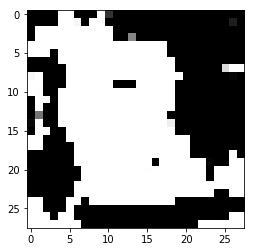

Epoch 2/2... Discriminator Loss: 0.4414... Generator Loss: 3.2167


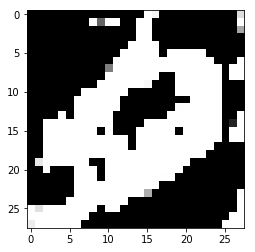

Epoch 2/2... Discriminator Loss: 0.3811... Generator Loss: 5.9255


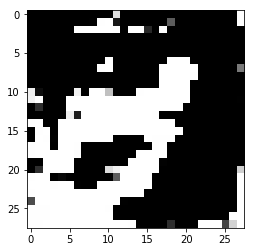

Epoch 2/2... Discriminator Loss: 0.8462... Generator Loss: 1.7318


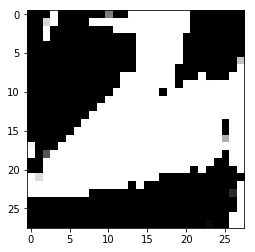

Epoch 2/2... Discriminator Loss: 1.0076... Generator Loss: 0.9215


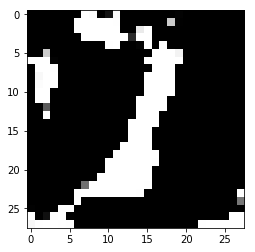

Epoch 2/2... Discriminator Loss: 0.6282... Generator Loss: 3.8886


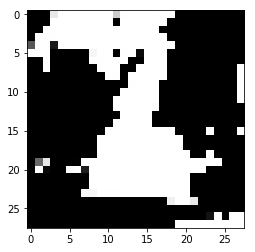

Epoch 2/2... Discriminator Loss: 0.4893... Generator Loss: 5.9171


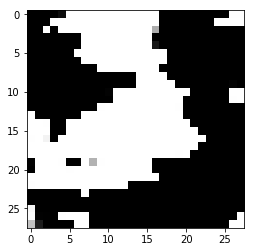

Epoch 2/2... Discriminator Loss: 1.6811... Generator Loss: 0.5746


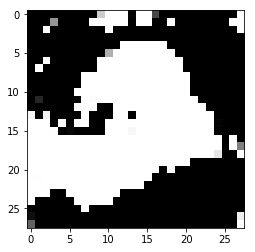

Epoch 2/2... Discriminator Loss: 0.8027... Generator Loss: 3.8036


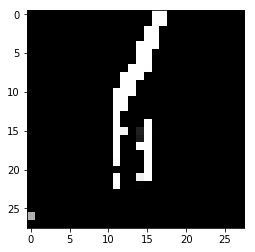

Epoch 2/2... Discriminator Loss: 1.0000... Generator Loss: 5.2840


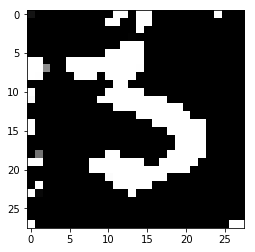

Epoch 2/2... Discriminator Loss: 0.5003... Generator Loss: 2.4055


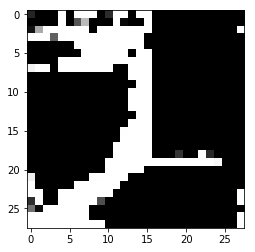

Epoch 2/2... Discriminator Loss: 0.5184... Generator Loss: 2.5896


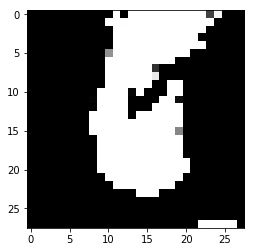

Epoch 2/2... Discriminator Loss: 0.5305... Generator Loss: 4.2397


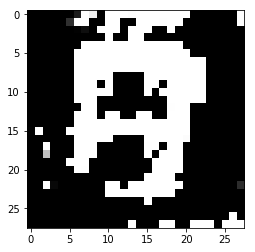

Epoch 2/2... Discriminator Loss: 0.6021... Generator Loss: 1.7149


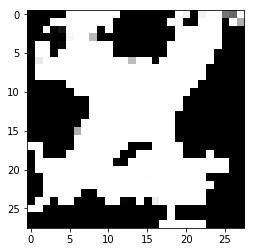

Epoch 2/2... Discriminator Loss: 0.6367... Generator Loss: 2.6482


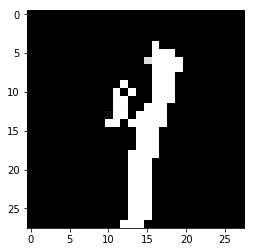

Epoch 2/2... Discriminator Loss: 0.9736... Generator Loss: 4.6707


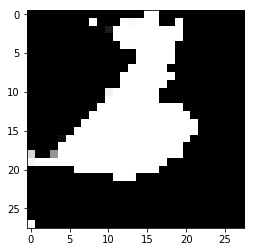

Epoch 2/2... Discriminator Loss: 0.6980... Generator Loss: 1.6711


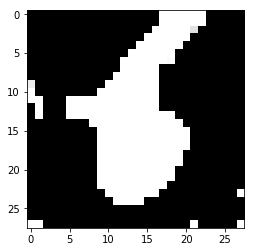

Epoch 2/2... Discriminator Loss: 0.9162... Generator Loss: 1.3102


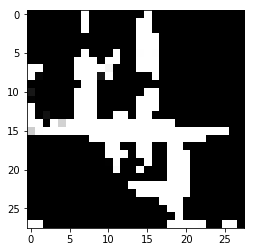

Epoch 2/2... Discriminator Loss: 0.5734... Generator Loss: 1.8348


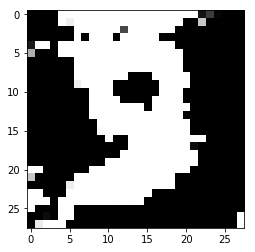

Epoch 2/2... Discriminator Loss: 1.5402... Generator Loss: 0.5986


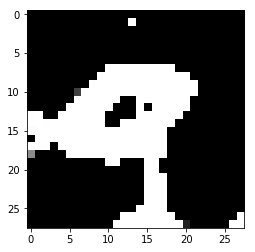

Epoch 2/2... Discriminator Loss: 0.4815... Generator Loss: 3.5468


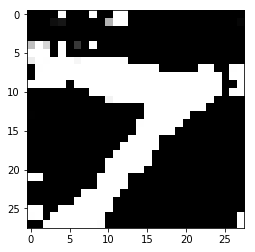

Epoch 2/2... Discriminator Loss: 0.9877... Generator Loss: 5.1496


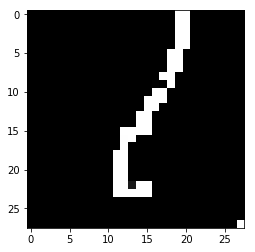

Epoch 2/2... Discriminator Loss: 0.4506... Generator Loss: 4.2138


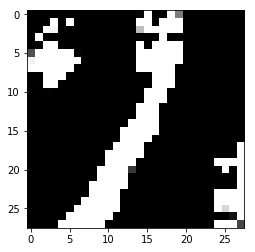

Epoch 2/2... Discriminator Loss: 0.7920... Generator Loss: 2.5722


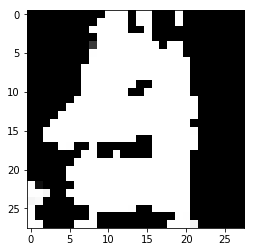

Epoch 2/2... Discriminator Loss: 0.6695... Generator Loss: 1.9239


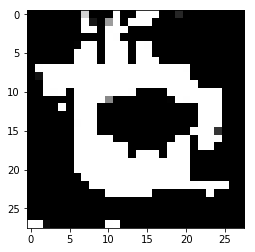

Epoch 2/2... Discriminator Loss: 0.5779... Generator Loss: 4.1357


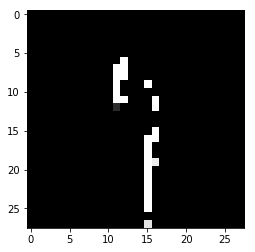

Epoch 2/2... Discriminator Loss: 0.6137... Generator Loss: 3.5324


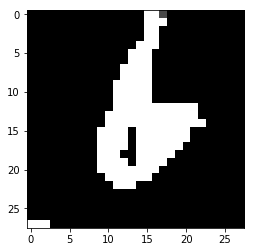

Epoch 2/2... Discriminator Loss: 0.7009... Generator Loss: 2.1481


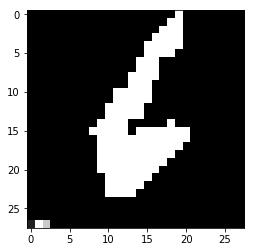

Epoch 2/2... Discriminator Loss: 0.5348... Generator Loss: 2.4357


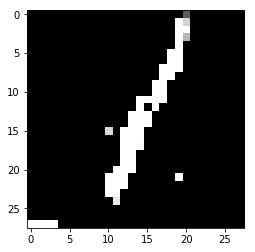

Epoch 2/2... Discriminator Loss: 0.4722... Generator Loss: 2.9130


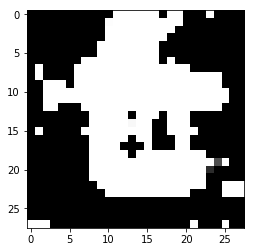

Epoch 2/2... Discriminator Loss: 0.8295... Generator Loss: 2.6736


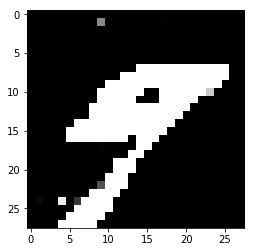

Epoch 2/2... Discriminator Loss: 0.7414... Generator Loss: 1.3794


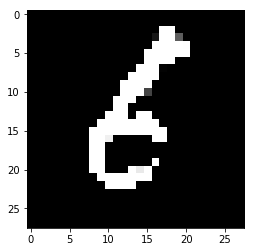

Epoch 2/2... Discriminator Loss: 0.5171... Generator Loss: 5.3677


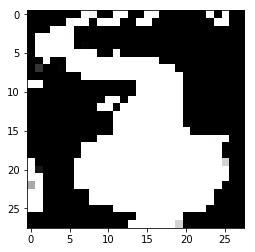

Epoch 2/2... Discriminator Loss: 0.4474... Generator Loss: 2.8829


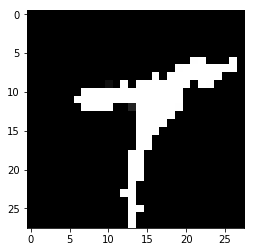

Epoch 2/2... Discriminator Loss: 0.6151... Generator Loss: 2.2757


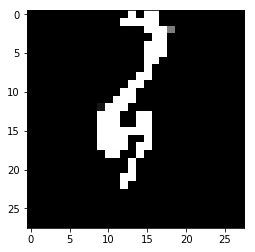

Epoch 2/2... Discriminator Loss: 0.7949... Generator Loss: 1.2531


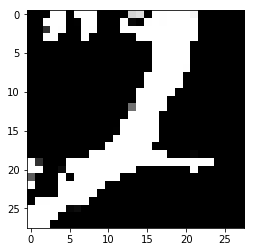

Epoch 2/2... Discriminator Loss: 0.5633... Generator Loss: 1.8686


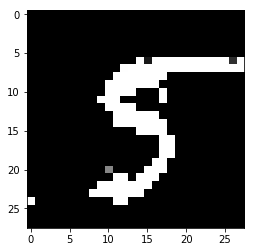

Epoch 2/2... Discriminator Loss: 0.5873... Generator Loss: 2.2166


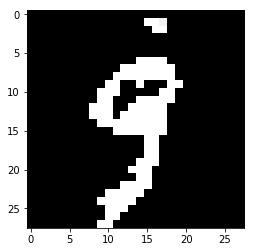

Epoch 2/2... Discriminator Loss: 1.1838... Generator Loss: 0.7818


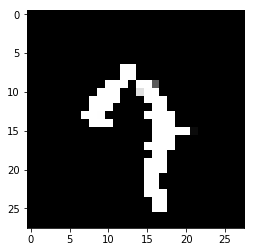

Epoch 2/2... Discriminator Loss: 0.4082... Generator Loss: 4.6333


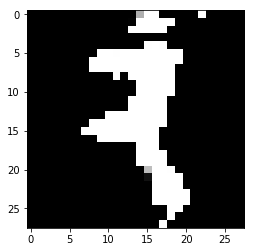

Epoch 2/2... Discriminator Loss: 0.7954... Generator Loss: 2.0704


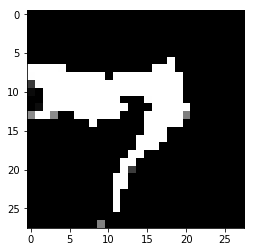

Epoch 2/2... Discriminator Loss: 0.5226... Generator Loss: 3.8976


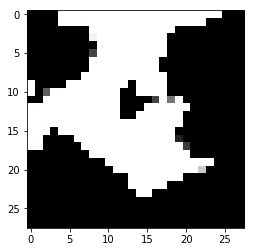

Epoch 2/2... Discriminator Loss: 0.4386... Generator Loss: 3.9812


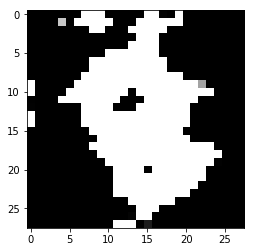

Epoch 2/2... Discriminator Loss: 0.4947... Generator Loss: 2.4401


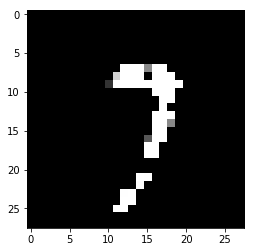

Epoch 2/2... Discriminator Loss: 0.8378... Generator Loss: 1.8128


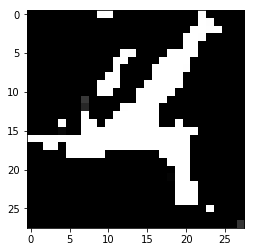

Epoch 2/2... Discriminator Loss: 0.9497... Generator Loss: 1.1484


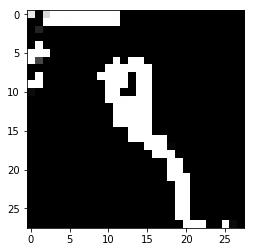

Epoch 2/2... Discriminator Loss: 0.4019... Generator Loss: 3.1667


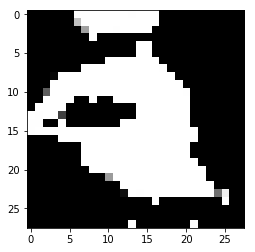

Epoch 2/2... Discriminator Loss: 0.4709... Generator Loss: 4.9807


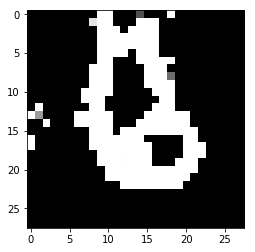

Epoch 2/2... Discriminator Loss: 0.6336... Generator Loss: 2.1513


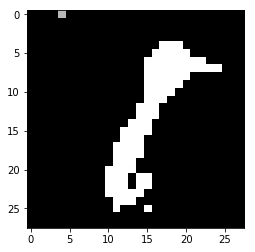

Epoch 2/2... Discriminator Loss: 0.6820... Generator Loss: 1.9171


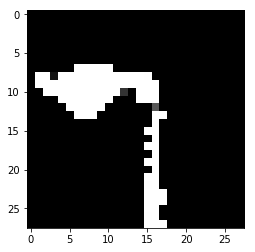

In [51]:
batch_size = 10
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.6200... Generator Loss: 2.8973


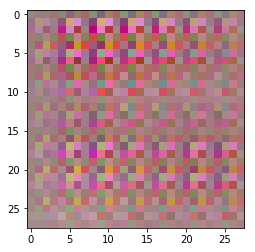

Epoch 1/1... Discriminator Loss: 0.5076... Generator Loss: 4.8779


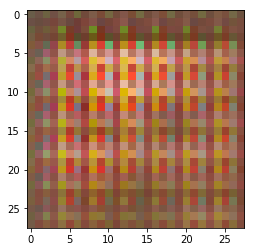

Epoch 1/1... Discriminator Loss: 0.4569... Generator Loss: 5.0768


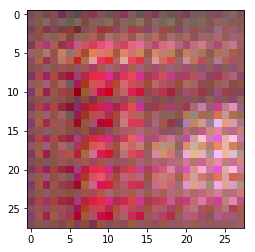

Epoch 1/1... Discriminator Loss: 0.7650... Generator Loss: 6.2384


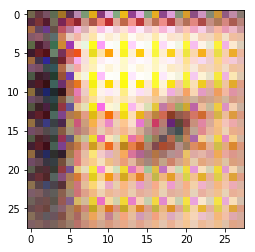

Epoch 1/1... Discriminator Loss: 0.4643... Generator Loss: 5.6959


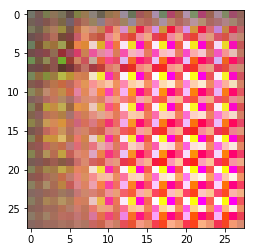

Epoch 1/1... Discriminator Loss: 0.3817... Generator Loss: 3.5715


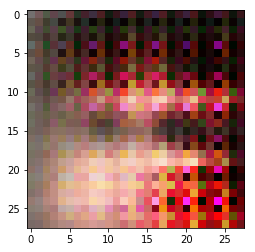

Epoch 1/1... Discriminator Loss: 0.4490... Generator Loss: 5.6166


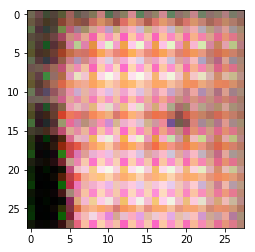

Epoch 1/1... Discriminator Loss: 0.6114... Generator Loss: 2.2834


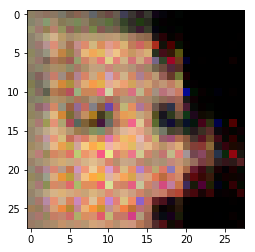

Epoch 1/1... Discriminator Loss: 0.4600... Generator Loss: 4.4586


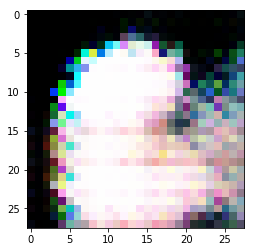

Epoch 1/1... Discriminator Loss: 1.0889... Generator Loss: 2.0975


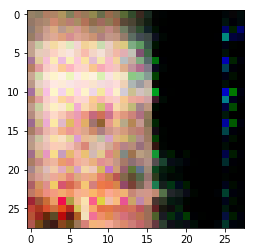

Epoch 1/1... Discriminator Loss: 0.4440... Generator Loss: 3.0671


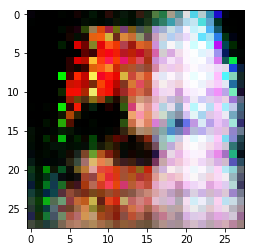

Epoch 1/1... Discriminator Loss: 0.6107... Generator Loss: 3.5351


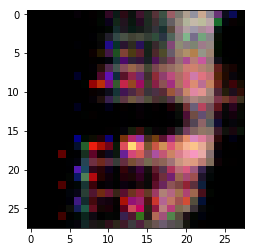

Epoch 1/1... Discriminator Loss: 0.5274... Generator Loss: 3.2101


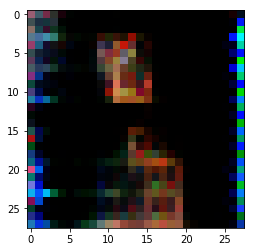

Epoch 1/1... Discriminator Loss: 0.6872... Generator Loss: 2.7043


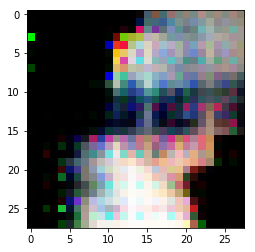

Epoch 1/1... Discriminator Loss: 0.5907... Generator Loss: 1.9196


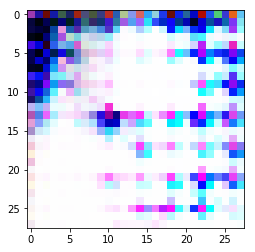

Epoch 1/1... Discriminator Loss: 0.6779... Generator Loss: 6.6755


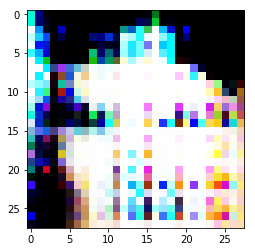

Epoch 1/1... Discriminator Loss: 0.7527... Generator Loss: 1.8766


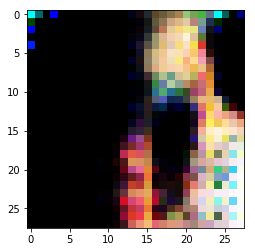

Epoch 1/1... Discriminator Loss: 0.5393... Generator Loss: 3.7140


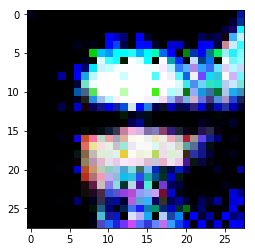

Epoch 1/1... Discriminator Loss: 0.6534... Generator Loss: 3.5891


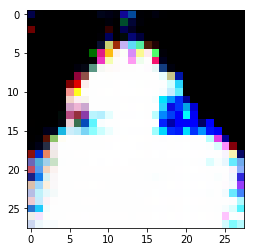

Epoch 1/1... Discriminator Loss: 0.3950... Generator Loss: 3.8731


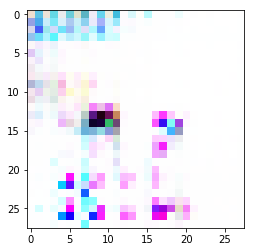

Epoch 1/1... Discriminator Loss: 0.6007... Generator Loss: 3.4396


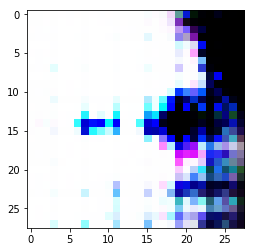

Epoch 1/1... Discriminator Loss: 0.6344... Generator Loss: 2.6745


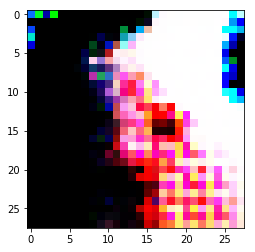

Epoch 1/1... Discriminator Loss: 0.5908... Generator Loss: 2.3850


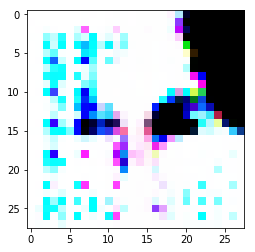

Epoch 1/1... Discriminator Loss: 0.5805... Generator Loss: 4.2605


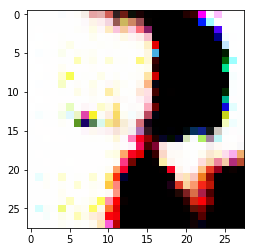

Epoch 1/1... Discriminator Loss: 0.4633... Generator Loss: 3.2008


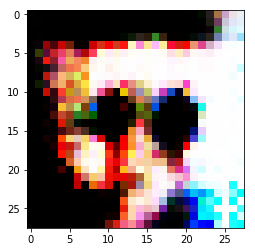

Epoch 1/1... Discriminator Loss: 0.6539... Generator Loss: 2.3645


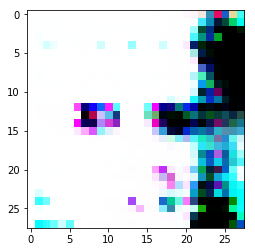

Epoch 1/1... Discriminator Loss: 0.4309... Generator Loss: 5.3956


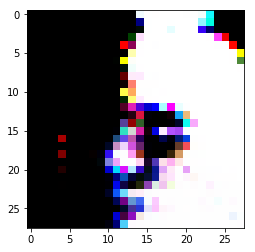

Epoch 1/1... Discriminator Loss: 0.5302... Generator Loss: 2.5331


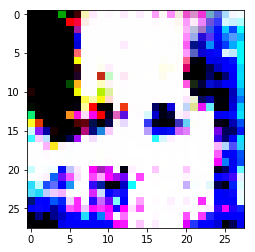

Epoch 1/1... Discriminator Loss: 0.5446... Generator Loss: 3.2016


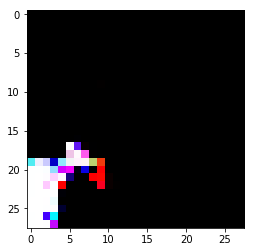

Epoch 1/1... Discriminator Loss: 0.6317... Generator Loss: 3.2970


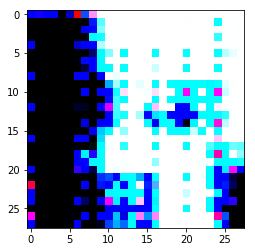

Epoch 1/1... Discriminator Loss: 1.2000... Generator Loss: 6.9233


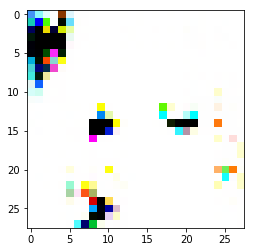

Epoch 1/1... Discriminator Loss: 0.7946... Generator Loss: 1.7493


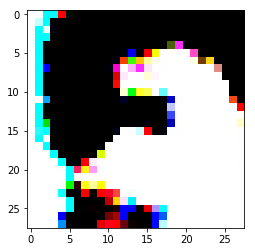

Epoch 1/1... Discriminator Loss: 0.5299... Generator Loss: 3.0758


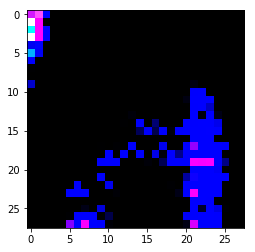

Epoch 1/1... Discriminator Loss: 0.5540... Generator Loss: 3.6297


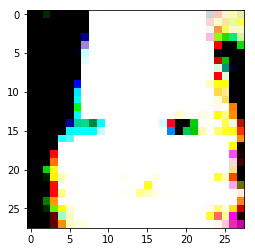

Epoch 1/1... Discriminator Loss: 0.4528... Generator Loss: 4.3683


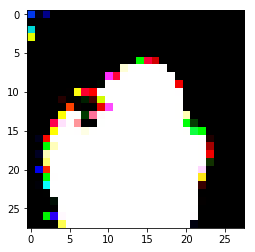

Epoch 1/1... Discriminator Loss: 0.8831... Generator Loss: 1.4825


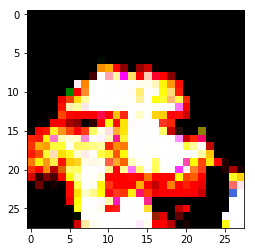

Epoch 1/1... Discriminator Loss: 0.8465... Generator Loss: 2.1289


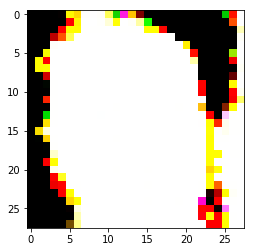

Epoch 1/1... Discriminator Loss: 0.5942... Generator Loss: 3.6623


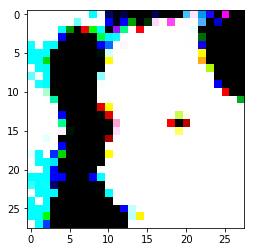

Epoch 1/1... Discriminator Loss: 0.5323... Generator Loss: 4.4488


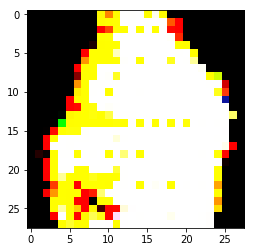

Epoch 1/1... Discriminator Loss: 0.5313... Generator Loss: 4.0316


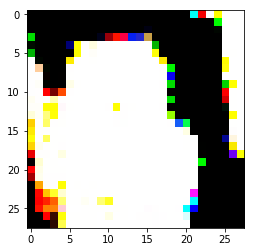

Epoch 1/1... Discriminator Loss: 0.5627... Generator Loss: 2.2988


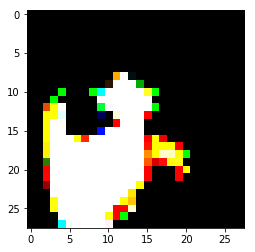

Epoch 1/1... Discriminator Loss: 0.5641... Generator Loss: 3.1095


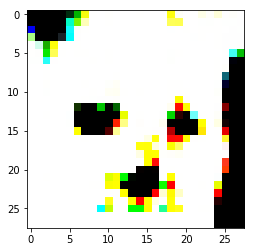

Epoch 1/1... Discriminator Loss: 0.5509... Generator Loss: 3.2544


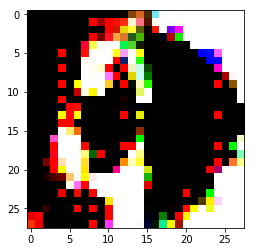

Epoch 1/1... Discriminator Loss: 1.3974... Generator Loss: 0.7429


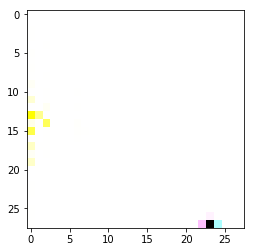

Epoch 1/1... Discriminator Loss: 0.5578... Generator Loss: 3.0046


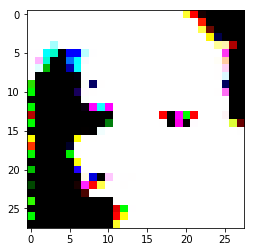

Epoch 1/1... Discriminator Loss: 0.5507... Generator Loss: 2.6913


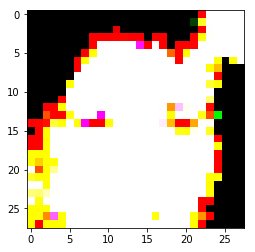

Epoch 1/1... Discriminator Loss: 0.6199... Generator Loss: 2.2438


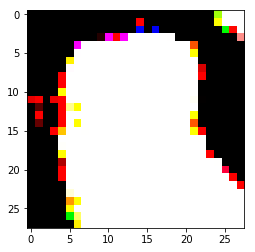

Epoch 1/1... Discriminator Loss: 0.6454... Generator Loss: 1.9027


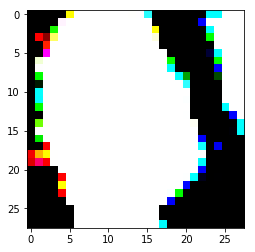

Epoch 1/1... Discriminator Loss: 0.8102... Generator Loss: 5.7207


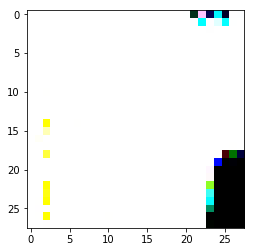

Epoch 1/1... Discriminator Loss: 0.5045... Generator Loss: 3.5733


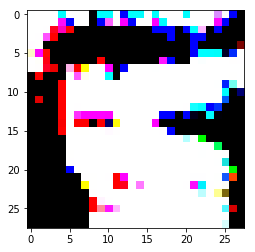

Epoch 1/1... Discriminator Loss: 0.4989... Generator Loss: 3.8321


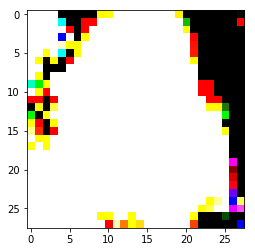

Epoch 1/1... Discriminator Loss: 0.7439... Generator Loss: 1.6107


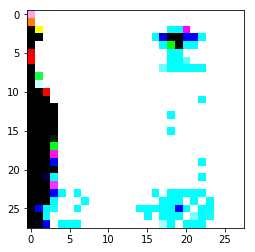

Epoch 1/1... Discriminator Loss: 0.6030... Generator Loss: 5.1381


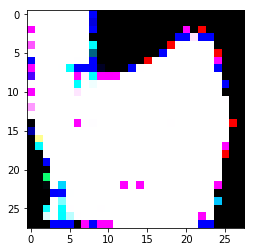

Epoch 1/1... Discriminator Loss: 0.5461... Generator Loss: 5.3951


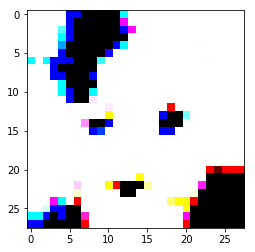

Epoch 1/1... Discriminator Loss: 0.7610... Generator Loss: 4.7485


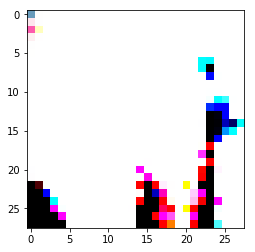

Epoch 1/1... Discriminator Loss: 0.4833... Generator Loss: 5.0852


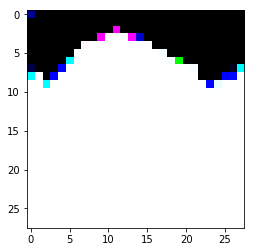

Epoch 1/1... Discriminator Loss: 0.4114... Generator Loss: 4.2600


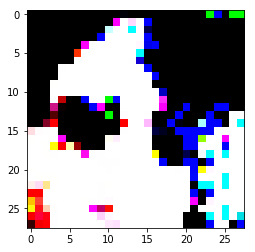

Epoch 1/1... Discriminator Loss: 0.4627... Generator Loss: 3.6426


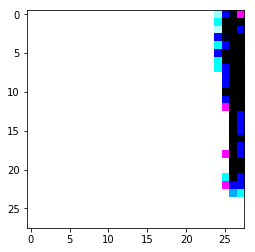

Epoch 1/1... Discriminator Loss: 0.6254... Generator Loss: 2.7160


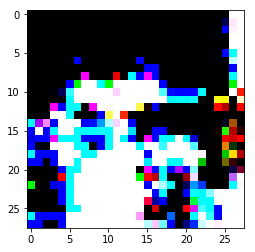

Epoch 1/1... Discriminator Loss: 0.6102... Generator Loss: 3.3019


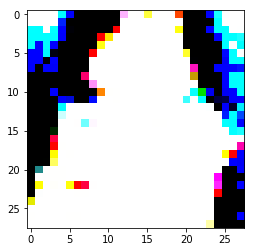

Epoch 1/1... Discriminator Loss: 0.4429... Generator Loss: 3.2073


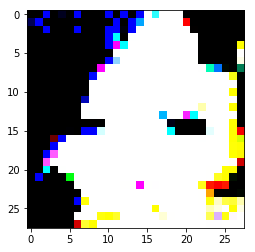

Epoch 1/1... Discriminator Loss: 0.8215... Generator Loss: 4.4552


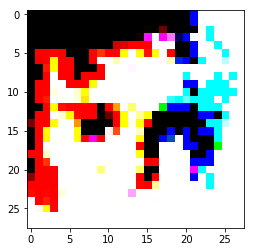

Epoch 1/1... Discriminator Loss: 1.0139... Generator Loss: 1.4019


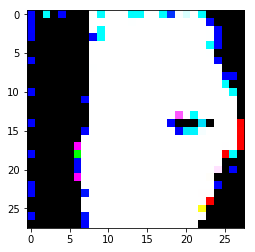

Epoch 1/1... Discriminator Loss: 0.4100... Generator Loss: 4.0132


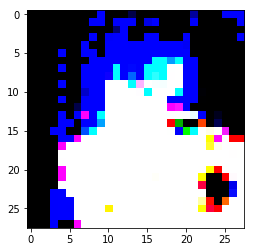

Epoch 1/1... Discriminator Loss: 0.5275... Generator Loss: 2.4415


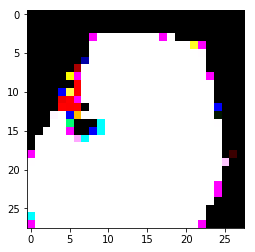

Epoch 1/1... Discriminator Loss: 0.4778... Generator Loss: 3.4278


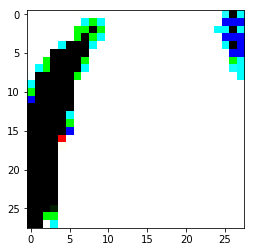

Epoch 1/1... Discriminator Loss: 0.3827... Generator Loss: 4.3688


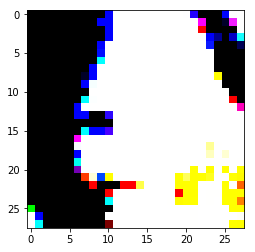

Epoch 1/1... Discriminator Loss: 0.6159... Generator Loss: 2.8229


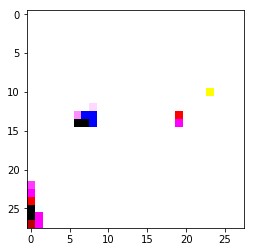

Epoch 1/1... Discriminator Loss: 0.6579... Generator Loss: 2.8499


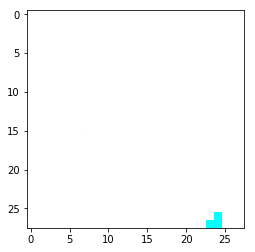

Epoch 1/1... Discriminator Loss: 0.5246... Generator Loss: 4.1133


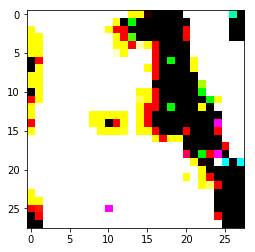

Epoch 1/1... Discriminator Loss: 0.5770... Generator Loss: 2.6837


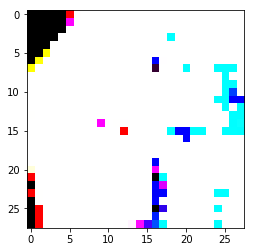

Epoch 1/1... Discriminator Loss: 0.7025... Generator Loss: 3.2559


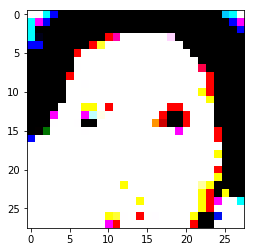

Epoch 1/1... Discriminator Loss: 0.5921... Generator Loss: 2.2899


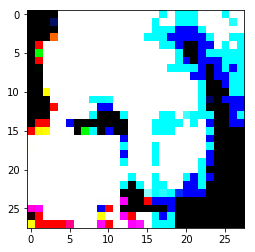

Epoch 1/1... Discriminator Loss: 0.4024... Generator Loss: 5.2651


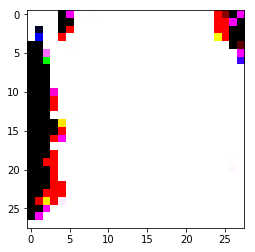

Epoch 1/1... Discriminator Loss: 0.5418... Generator Loss: 2.8773


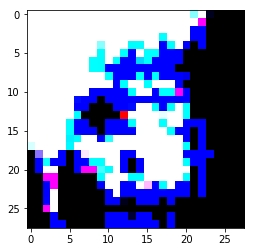

Epoch 1/1... Discriminator Loss: 0.5935... Generator Loss: 2.3595


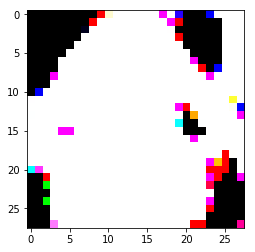

Epoch 1/1... Discriminator Loss: 0.7456... Generator Loss: 1.7298


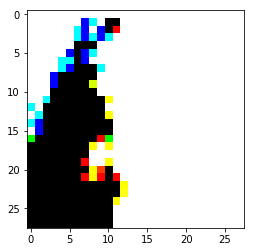

Epoch 1/1... Discriminator Loss: 0.8364... Generator Loss: 2.3648


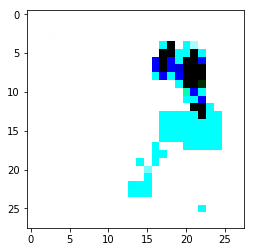

Epoch 1/1... Discriminator Loss: 0.8408... Generator Loss: 1.6797


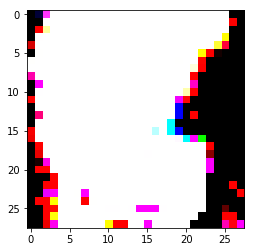

Epoch 1/1... Discriminator Loss: 0.6618... Generator Loss: 2.5383


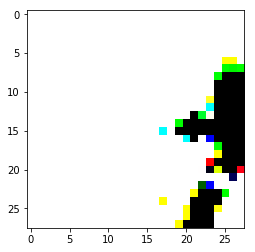

Epoch 1/1... Discriminator Loss: 0.4500... Generator Loss: 3.6296


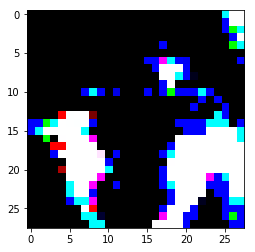

Epoch 1/1... Discriminator Loss: 0.9028... Generator Loss: 1.8429


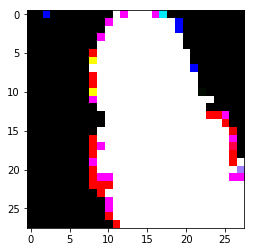

Epoch 1/1... Discriminator Loss: 0.5290... Generator Loss: 3.0459


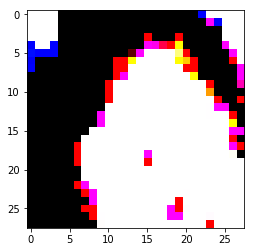

Epoch 1/1... Discriminator Loss: 0.4973... Generator Loss: 3.3468


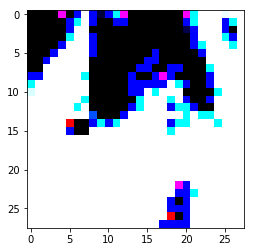

Epoch 1/1... Discriminator Loss: 0.5632... Generator Loss: 2.2889


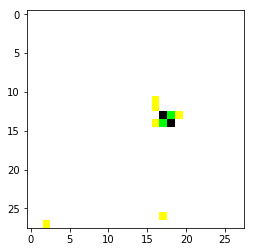

Epoch 1/1... Discriminator Loss: 0.8023... Generator Loss: 2.5481


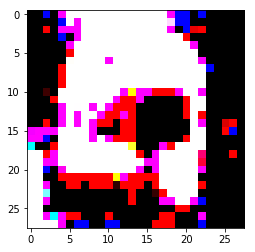

Epoch 1/1... Discriminator Loss: 0.4967... Generator Loss: 3.2005


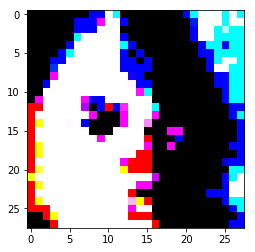

Epoch 1/1... Discriminator Loss: 0.7248... Generator Loss: 2.7115


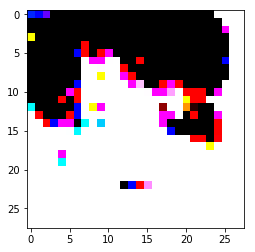

Epoch 1/1... Discriminator Loss: 0.5034... Generator Loss: 3.2157


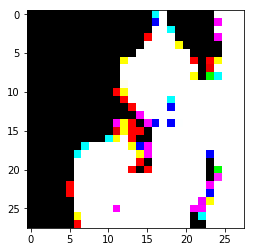

Epoch 1/1... Discriminator Loss: 0.6082... Generator Loss: 3.0374


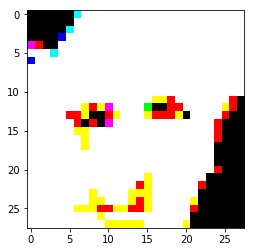

Epoch 1/1... Discriminator Loss: 1.0304... Generator Loss: 1.0242


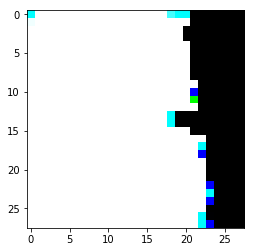

Epoch 1/1... Discriminator Loss: 0.4714... Generator Loss: 4.1813


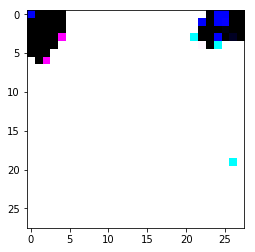

Epoch 1/1... Discriminator Loss: 0.7497... Generator Loss: 2.9729


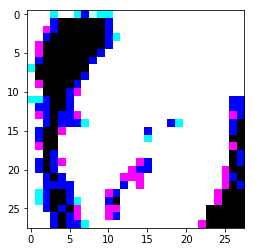

Epoch 1/1... Discriminator Loss: 0.8896... Generator Loss: 2.9101


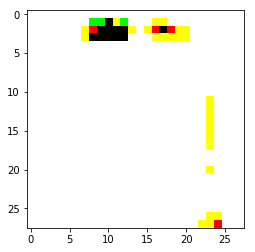

Epoch 1/1... Discriminator Loss: 0.8631... Generator Loss: 3.8788


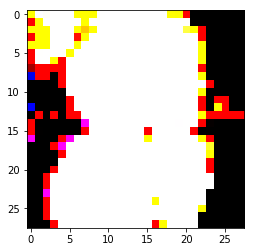

Epoch 1/1... Discriminator Loss: 0.7485... Generator Loss: 1.8752


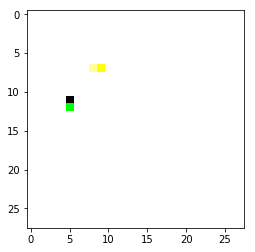

Epoch 1/1... Discriminator Loss: 0.7605... Generator Loss: 2.2840


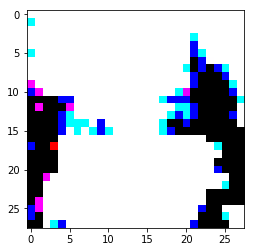

Epoch 1/1... Discriminator Loss: 1.0277... Generator Loss: 1.1605


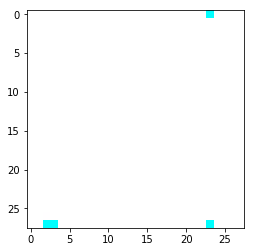

Epoch 1/1... Discriminator Loss: 0.5649... Generator Loss: 2.3698


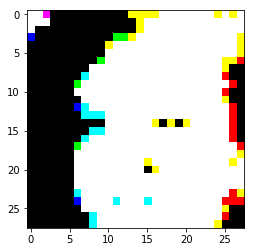

Epoch 1/1... Discriminator Loss: 0.8099... Generator Loss: 2.0251


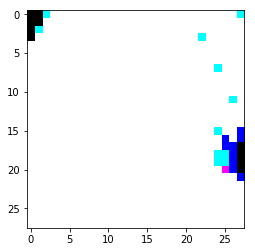

Epoch 1/1... Discriminator Loss: 0.6275... Generator Loss: 4.8866


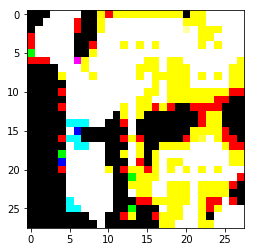

Epoch 1/1... Discriminator Loss: 1.4744... Generator Loss: 3.1387


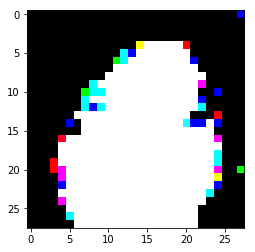

Epoch 1/1... Discriminator Loss: 1.2952... Generator Loss: 2.4298


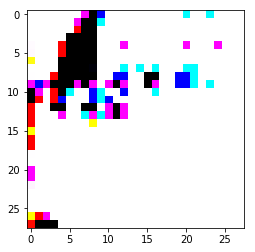

Epoch 1/1... Discriminator Loss: 0.5718... Generator Loss: 2.3520


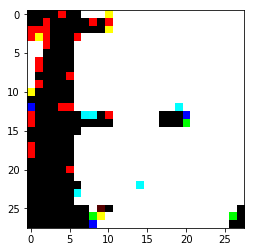

Epoch 1/1... Discriminator Loss: 0.7769... Generator Loss: 1.6332


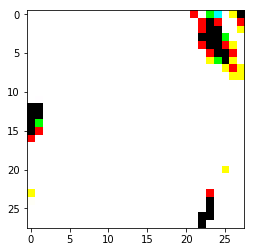

Epoch 1/1... Discriminator Loss: 0.4892... Generator Loss: 3.0349


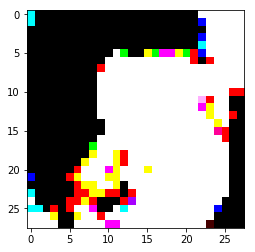

Epoch 1/1... Discriminator Loss: 0.6209... Generator Loss: 2.2660


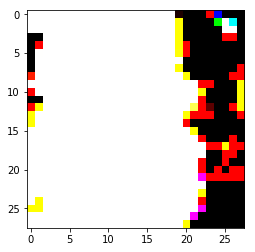

Epoch 1/1... Discriminator Loss: 0.9909... Generator Loss: 1.1145


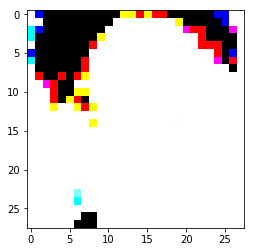

Epoch 1/1... Discriminator Loss: 0.8717... Generator Loss: 1.7911


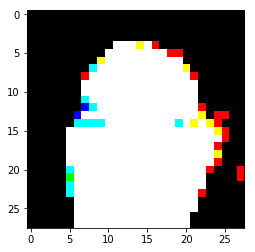

Epoch 1/1... Discriminator Loss: 0.7256... Generator Loss: 1.8374


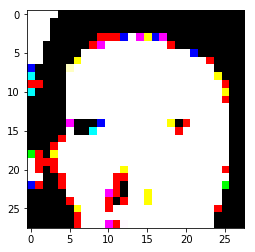

Epoch 1/1... Discriminator Loss: 0.5982... Generator Loss: 2.4176


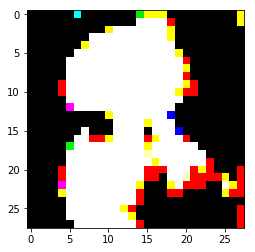

Epoch 1/1... Discriminator Loss: 0.6040... Generator Loss: 2.5344


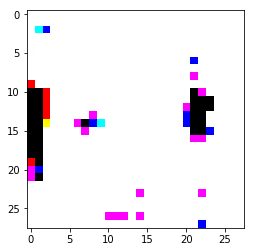

Epoch 1/1... Discriminator Loss: 0.6062... Generator Loss: 2.9541


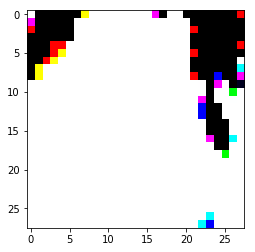

Epoch 1/1... Discriminator Loss: 0.6376... Generator Loss: 2.8180


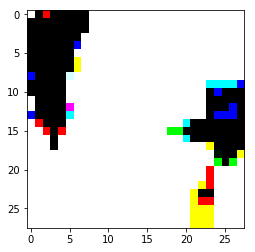

Epoch 1/1... Discriminator Loss: 1.1629... Generator Loss: 1.6719


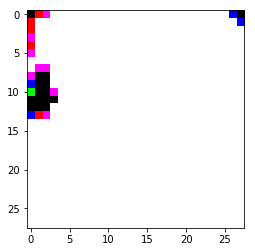

Epoch 1/1... Discriminator Loss: 0.8881... Generator Loss: 2.1719


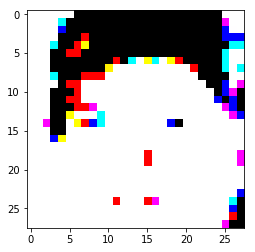

Epoch 1/1... Discriminator Loss: 1.0140... Generator Loss: 1.1895


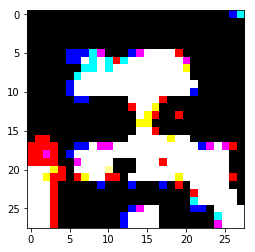

Epoch 1/1... Discriminator Loss: 0.5391... Generator Loss: 2.2581


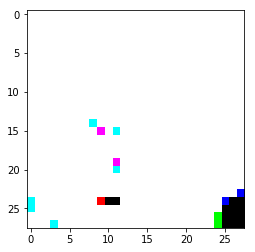

Epoch 1/1... Discriminator Loss: 0.6348... Generator Loss: 2.5973


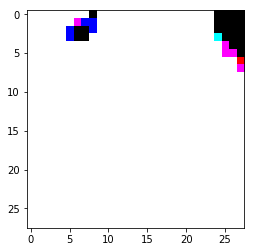

Epoch 1/1... Discriminator Loss: 0.5574... Generator Loss: 2.3131


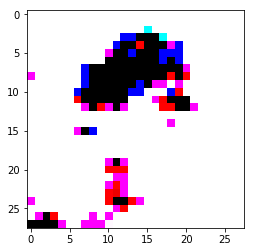

Epoch 1/1... Discriminator Loss: 0.8072... Generator Loss: 2.0562


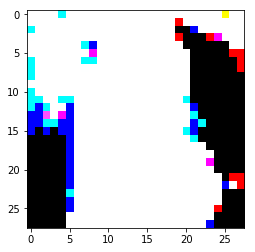

Epoch 1/1... Discriminator Loss: 0.9442... Generator Loss: 2.0422


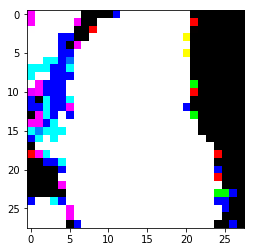

Epoch 1/1... Discriminator Loss: 1.0682... Generator Loss: 1.3267


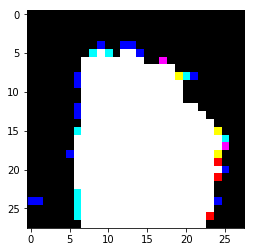

Epoch 1/1... Discriminator Loss: 0.8641... Generator Loss: 1.3322


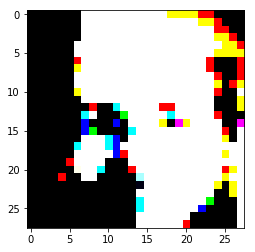

Epoch 1/1... Discriminator Loss: 0.6377... Generator Loss: 2.0034


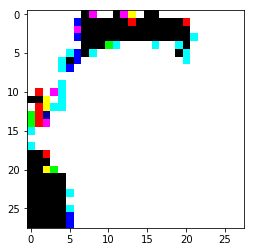

Epoch 1/1... Discriminator Loss: 0.6984... Generator Loss: 2.8331


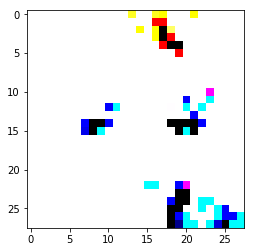

Epoch 1/1... Discriminator Loss: 0.5396... Generator Loss: 3.0409


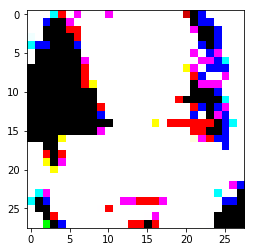

Epoch 1/1... Discriminator Loss: 0.9004... Generator Loss: 1.6849


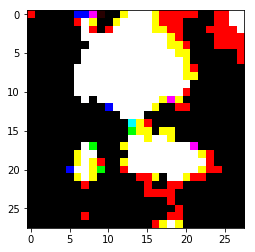

Epoch 1/1... Discriminator Loss: 0.7191... Generator Loss: 2.6543


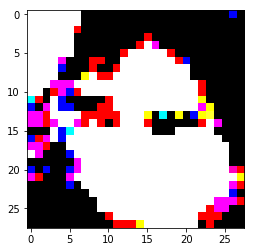

Epoch 1/1... Discriminator Loss: 1.5035... Generator Loss: 1.2734


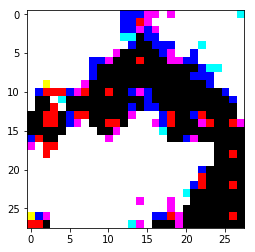

Epoch 1/1... Discriminator Loss: 0.6824... Generator Loss: 2.1161


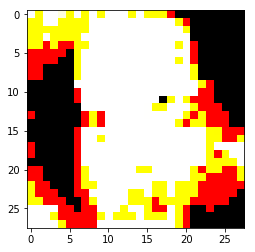

Epoch 1/1... Discriminator Loss: 0.7622... Generator Loss: 2.0575


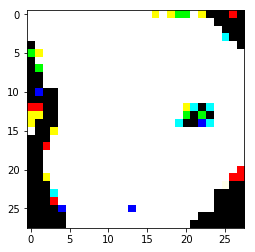

Epoch 1/1... Discriminator Loss: 0.4803... Generator Loss: 3.5371


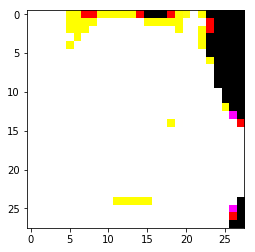

Epoch 1/1... Discriminator Loss: 0.4928... Generator Loss: 4.0034


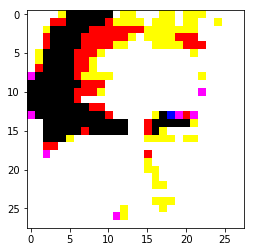

Epoch 1/1... Discriminator Loss: 0.5569... Generator Loss: 2.5504


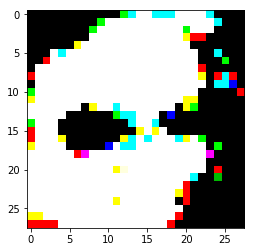

Epoch 1/1... Discriminator Loss: 1.1492... Generator Loss: 2.1262


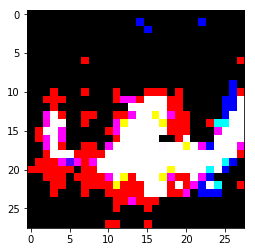

Epoch 1/1... Discriminator Loss: 0.5185... Generator Loss: 3.0182


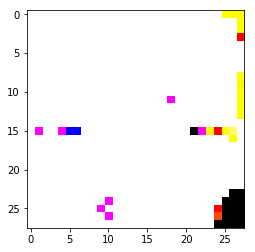

Epoch 1/1... Discriminator Loss: 0.6110... Generator Loss: 2.1734


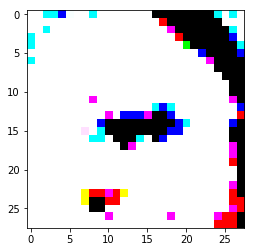

Epoch 1/1... Discriminator Loss: 1.1843... Generator Loss: 0.8354


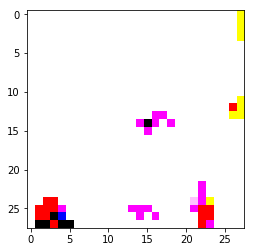

Epoch 1/1... Discriminator Loss: 0.7037... Generator Loss: 1.8814


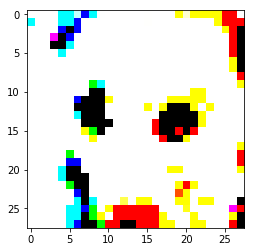

Epoch 1/1... Discriminator Loss: 0.8727... Generator Loss: 1.6329


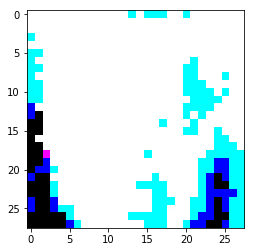

Epoch 1/1... Discriminator Loss: 1.1876... Generator Loss: 3.1103


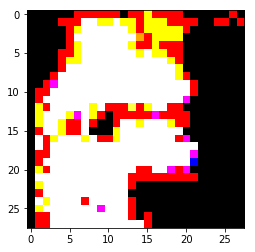

Epoch 1/1... Discriminator Loss: 0.9625... Generator Loss: 2.3208


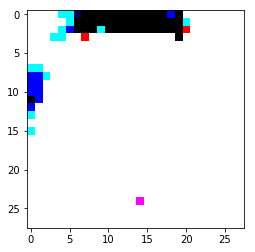

Epoch 1/1... Discriminator Loss: 0.7220... Generator Loss: 2.7066


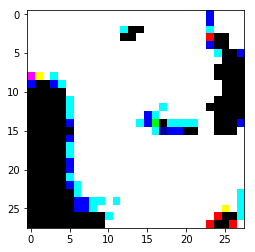

Epoch 1/1... Discriminator Loss: 0.8763... Generator Loss: 1.3668


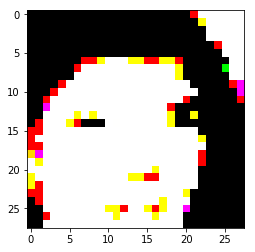

Epoch 1/1... Discriminator Loss: 0.8924... Generator Loss: 2.2613


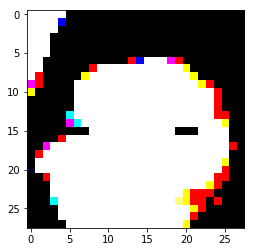

Epoch 1/1... Discriminator Loss: 1.0928... Generator Loss: 1.5166


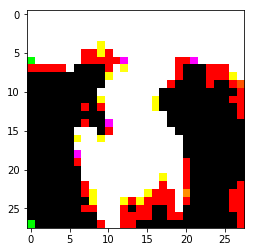

Epoch 1/1... Discriminator Loss: 0.4745... Generator Loss: 3.2816


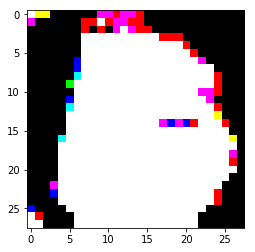

Epoch 1/1... Discriminator Loss: 0.8626... Generator Loss: 1.8985


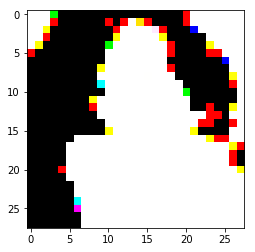

Epoch 1/1... Discriminator Loss: 0.8408... Generator Loss: 2.8508


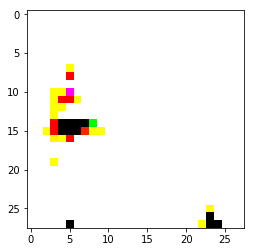

Epoch 1/1... Discriminator Loss: 0.5175... Generator Loss: 3.3447


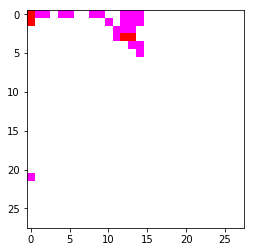

Epoch 1/1... Discriminator Loss: 0.7313... Generator Loss: 2.8090


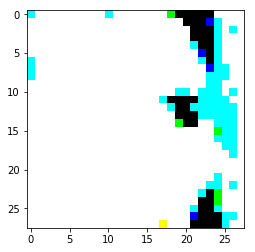

Epoch 1/1... Discriminator Loss: 0.9604... Generator Loss: 2.3203


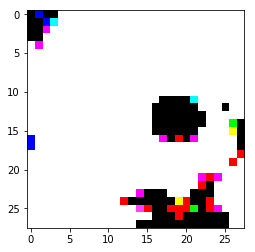

Epoch 1/1... Discriminator Loss: 0.6837... Generator Loss: 2.2414


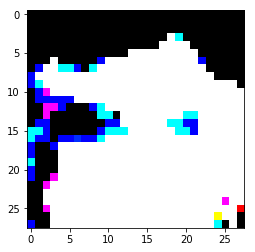

Epoch 1/1... Discriminator Loss: 0.7847... Generator Loss: 1.3440


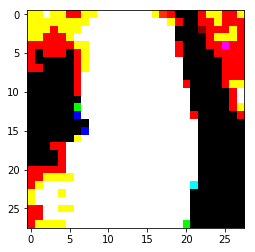

Epoch 1/1... Discriminator Loss: 1.7045... Generator Loss: 1.6428


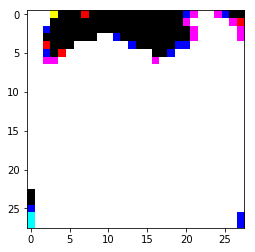

Epoch 1/1... Discriminator Loss: 0.5819... Generator Loss: 2.5661


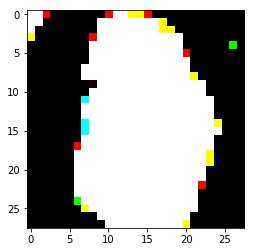

Epoch 1/1... Discriminator Loss: 0.5414... Generator Loss: 3.3160


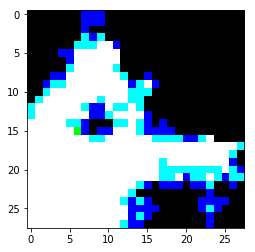

Epoch 1/1... Discriminator Loss: 0.7708... Generator Loss: 2.4770


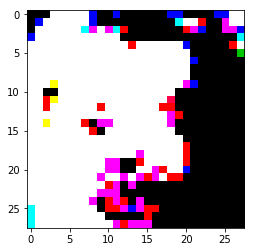

Epoch 1/1... Discriminator Loss: 1.4423... Generator Loss: 3.4645


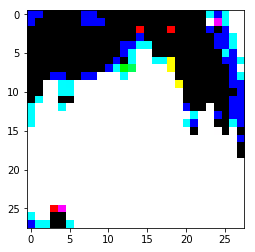

Epoch 1/1... Discriminator Loss: 0.6045... Generator Loss: 1.9927


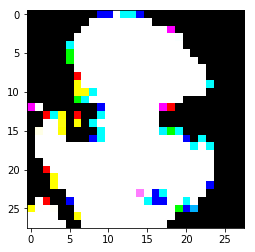

Epoch 1/1... Discriminator Loss: 0.8585... Generator Loss: 1.8454


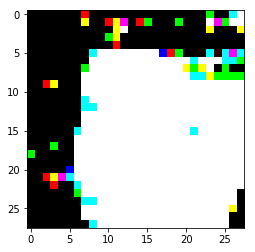

Epoch 1/1... Discriminator Loss: 1.1332... Generator Loss: 1.3425


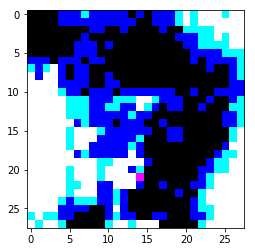

Epoch 1/1... Discriminator Loss: 1.0401... Generator Loss: 1.0991


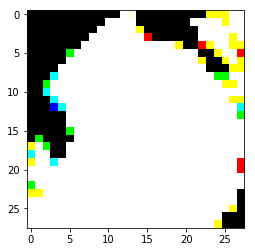

Epoch 1/1... Discriminator Loss: 0.9581... Generator Loss: 1.8575


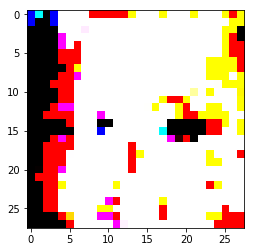

Epoch 1/1... Discriminator Loss: 0.6347... Generator Loss: 2.4459


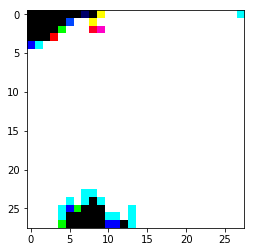

Epoch 1/1... Discriminator Loss: 0.7688... Generator Loss: 3.8686


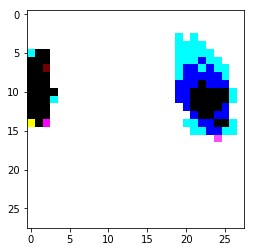

Epoch 1/1... Discriminator Loss: 0.6012... Generator Loss: 2.4596


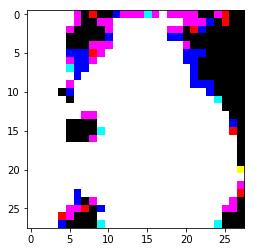

Epoch 1/1... Discriminator Loss: 0.7607... Generator Loss: 2.7686


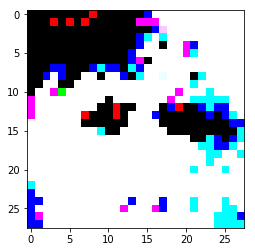

Epoch 1/1... Discriminator Loss: 0.7053... Generator Loss: 2.3137


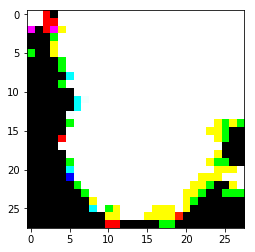

In [ ]:
batch_size = 10
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.